In [1]:
import geopandas as gpd
import pandas as pd

import duckdb


import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


In [2]:
duckdb.sql("SELECT 42").show()

┌───────┐
│  42   │
│ int32 │
├───────┤
│    42 │
└───────┘



In [3]:
## PBF history runterladen  
# https://osm-internal.download.geofabrik.de/europe/germany/brandenburg.html


In [4]:
# alles changsets runterlade, (nur hier sind die hashtags drin) changesets-latest.osm.bz2  
# https://planet.openstreetmap.org/planet/


# zeitlich and räumlich  filtern (geht ziemlich lang, > 15min)
# # grobe Deutschland-BBox: lon_min,lat_min,lon_max,lat_max
# DE_BBOX="5.5,47.2,15.1,55.1"

# osmium changeset-filter \
#   --after 2020-01-01T00:00:00Z \
#   --bbox $DE_BBOX \
#   -o changesets-DE-2020plus.osm.bz2 \
#   changesets-251006.osm.bz2


###### viellericht alternative besser , denn das dauert 1 h
# bunzip2 -k ~/ohsome-planet/data/changesets-DE-2020plus.osm.bz2

# # in postgres erstellen
# cd ~/ChangesetMD
# python3 changesetmd.py \
#   -c \
#   -H localhost \
#   -u osm \
#   -p osm \
#   -d changesetmd

# # in postgres reinladen
# python3 changesetmd.py \
#   -f ~/ohsome-planet/data/changesets-DE-2020plus.osm \
#   -H localhost \
#   -u osm \
#   -p osm \
#   -d changesetmd


######  alternative rust bib zu csv, dann csv in postgres laden ....



In [5]:
# simon@LAPTOP-T25KRUB6:~/ohsome-planet$ java -jar ohsome-planet-cli/target/ohsome-planet.jar contributions \
#   --pbf data/berlin-internal.osh.pbf \
#   --output out-berlin \
#   --overwrite
# read blocks 100% │████████████████│ 362/362 MiB (0:00:00 / 0:00:00) 2848 blocks
# process     node 100% │████████████████████│ 2130/2130 blk (0:00:13 / 0:00:00)
# process      way 100% │██████████████████████│ 652/652 blk (0:00:33 / 0:00:00)
# process relation 100% │████████████████████████│ 66/66 blk (0:01:22 / 0:00:00)
# done in 2.084 min


## TODO: TAGS????

In [6]:

duckdb.sql("INSTALL spatial; LOAD spatial;")

duckdb.sql("""
CREATE OR REPLACE TABLE tmp2 AS
SELECT
  ST_GeomFromWKB(geometry) AS geom,
  tags,
  changeset,
  user,
           
FROM read_parquet(
  ['~/ohsome-planet/out-germany_cs/contributions/history/way*-*-history-contribs.parquet',
   '~/ohsome-planet/out-germany_cs/contributions/latest/way*-*-latest-contribs.parquet'],
  union_by_name=true
)
WHERE
 (
    COALESCE(changeset.tags.hashtags, '') ILIKE '%#missing-cw_mapillary-signs%'
  )
""")


# valid_from >= DATE '2025-01-01' AND

# WHERE tags['highway'] = 'cycleway' OR tags['highway'] = 'path'
# AND length_delta > 0
# user.name == 'fmc_9'

# user.name IN ('fmc_6', 'fmc_7', 'fmc_8', 'fmc_9', 'fmc_10')

# changeset.tags.hashtags IN ('#fmc_vorrangnetz') 


rows = duckdb.sql("SELECT ST_AsText(geom) AS wkt, tags, changeset, user FROM tmp2").fetchall()


gdf = gpd.GeoDataFrame.from_records(rows, columns=["wkt", "tags", "changeset", "user"])
gdf["geometry"] = gpd.GeoSeries.from_wkt(gdf["wkt"])
gdf = gdf.set_geometry("geometry", crs="EPSG:4326")
gdf#.head()



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_734/2106550180.py:38: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf["geometry"] = gpd.GeoSeries.from_wkt(gdf["wkt"])


,wkt,tags,changeset,user,geometry
0,"LINESTRING (11.8477091 50.8897581, 11.847593 5...","{'cycleway:left': 'no', 'name': 'Robert-Friese...","{'id': 171948163, 'created_at': 2025-09-15 06:...","{'id': 3644159, 'name': 'bicyclett'}","LINESTRING (11.84771 50.88976, 11.84759 50.88993)"
1,"LINESTRING (10.0998905 52.8451411, 10.0995923 ...","{'highway': 'service', 'sidewalk': 'left', 'lc...","{'id': 170571393, 'created_at': 2025-08-17 15:...","{'id': 3644159, 'name': 'bicyclett'}","LINESTRING (10.09989 52.84514, 10.09959 52.845..."
2,"LINESTRING (9.209622 48.0880089, 9.2093329 48....","{'highway': 'path', 'foot': 'designated', 'tra...","{'id': 172234852, 'created_at': 2025-09-21 08:...","{'id': 3644159, 'name': 'bicyclett'}","LINESTRING (9.20962 48.08801, 9.20933 48.08823..."
3,"LINESTRING (9.2158464 48.0890546, 9.2161976 48...",{},"{'id': 172234852, 'created_at': 2025-09-21 08:...","{'id': 3644159, 'name': 'bicyclett'}","LINESTRING (9.21585 48.08905, 9.2162 48.08906,..."
4,"LINESTRING (8.8291378 50.1198593, 8.8291423 50...",{},"{'id': 172427080, 'created_at': 2025-09-25 08:...","{'id': 3644159, 'name': 'bicyclett'}","LINESTRING (8.82914 50.11986, 8.82914 50.11976..."
...,...,...,...,...,...
2434,"LINESTRING (12.3411906 49.8728359, 12.3412142 ...","{'segregated': 'no', 'highway': 'path', 'foot'...","{'id': 172739536, 'created_at': 2025-10-02 09:...","{'id': 3644159, 'name': 'bicyclett'}","LINESTRING (12.34119 49.87284, 12.34121 49.872..."
2435,"LINESTRING (12.3414918 49.8722264, 12.3415925 ...","{'highway': 'path', 'foot': 'designated', 'tra...","{'id': 172739536, 'created_at': 2025-10-02 09:...","{'id': 3644159, 'name': 'bicyclett'}","LINESTRING (12.34149 49.87223, 12.34159 49.872..."
2436,"LINESTRING (12.341406 49.8722864, 12.3412489 4...","{'surface': 'asphalt', 'lit': 'yes', 'foot': '...","{'id': 172739536, 'created_at': 2025-10-02 09:...","{'id': 3644159, 'name': 'bicyclett'}","LINESTRING (12.34141 49.87229, 12.34125 49.87229)"
2437,"LINESTRING (12.341406 49.8722864, 12.3414655 4...",{'highway': 'steps'},"{'id': 172739536, 'created_at': 2025-10-02 09:...","{'id': 3644159, 'name': 'bicyclett'}","LINESTRING (12.34141 49.87229, 12.34147 49.87229)"


In [7]:
gdf["changeset_id"] = gdf["changeset"].apply(lambda u: u.get("id") if isinstance(u, dict) else None)
gdf["highway"] = gdf["tags"].apply(lambda u: u.get("highway") if isinstance(u, dict) else None)
gdf["hashtags"] = gdf["changeset"].apply(lambda u: u.get("tags").get("hashtags") if isinstance(u, dict) else None)
gdf["user_name"] = gdf["user"].apply(lambda u: u.get("name") if isinstance(u, dict) else None)

In [8]:
gdf=gdf[gdf.highway.notnull()].copy()

In [9]:
#gdf.plot(column="user_name", legend=True)

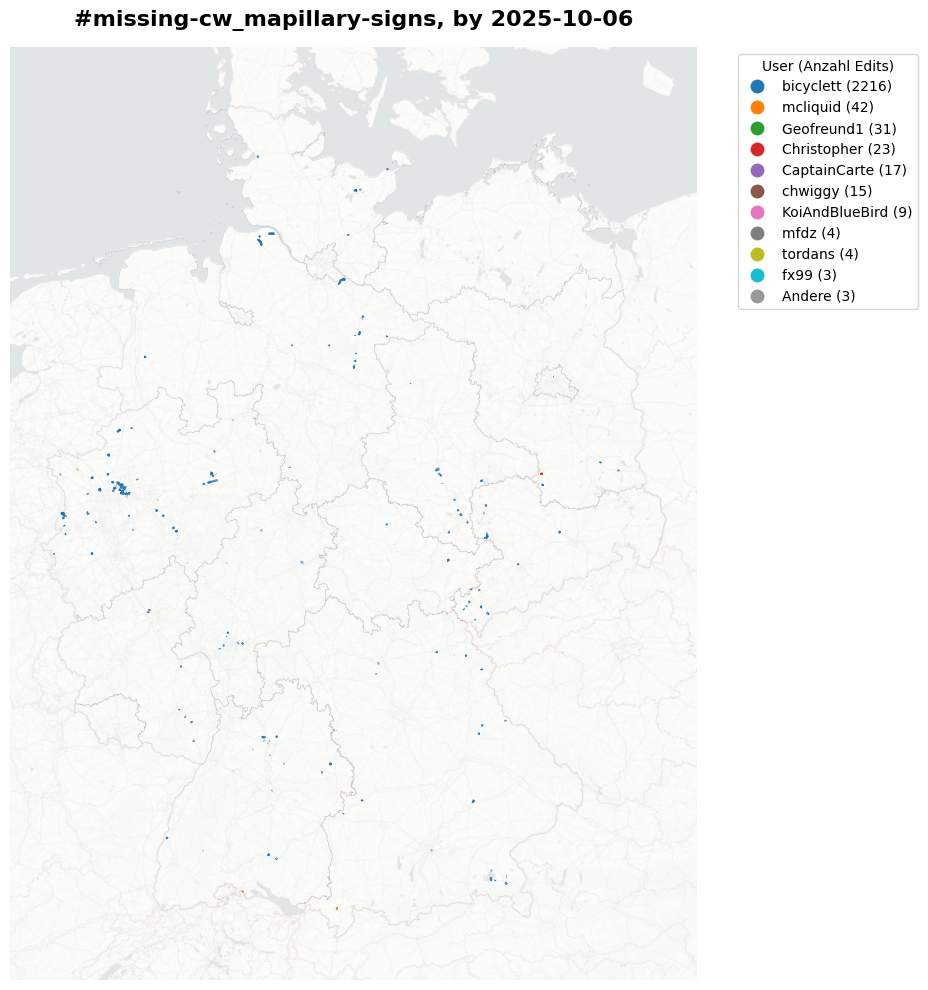

In [10]:
# !pip install contextily  # einmalig, falls noch nicht installiert
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
import contextily as cx

# --- Top-10 + "Andere" wie zuvor ---
top10 = gdf["user_name"].value_counts().head(10)
gdf["user_plot"] = gdf["user_name"].where(gdf["user_name"].isin(top10.index), "Andere")
order = list(top10.index) + ["Andere"]
gdf["user_plot"] = pd.Categorical(gdf["user_plot"], categories=order, ordered=True)

# feste Farbzuordnung in genau dieser Reihenfolge (letzte Farbe neutral/grau für "Andere")
base_cmap = plt.cm.tab20
colors = base_cmap(np.linspace(0, 1, len(order)))
colors[-1] = (0.6, 0.6, 0.6, 1.0)  # "Andere" grau
cmap = ListedColormap(colors)



# Daten laden
shape = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/2_bundeslaender/1_sehr_hoch.geo.json")


# --- Reprojektion auf Web-Mercator für die Basemap ---
gdf3857 = gdf.to_crs(epsg=3857)
shape_3857 = shape.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(14, 10))

# 🔹 Shape hinzufügen (kein Legendeneintrag)
shape_3857.boundary.plot(
    ax=ax,
    color="black",       # oder z. B. "black", "darkgrey"
    linewidth=0.03,
    label="_nolegend_" # verhindert Legendeneintrag
)



# 1) Vektordaten plotten (über der Basemap)
gdf3857.plot(
    column="user_plot",
    categorical=True,
    legend=True,
    cmap=cmap,
    ax=ax,
    legend_kwds={
        "bbox_to_anchor": (1.05, 1),
        "loc": "upper left",
        "title": "User (Anzahl Edits)"
    },
    zorder=2
)

# 2) Legendentexte umbenennen (Anzahl in Klammern), Reihenfolge bleibt unverändert
leg = ax.get_legend()
if leg:
    others = int((gdf["user_plot"] == "Andere").sum())
    rename_map = {u: f"{u} ({top10[u]})" for u in top10.index}
    rename_map["Andere"] = f"Andere ({others})"
    for t in leg.get_texts():
        lbl = t.get_text()
        if lbl in rename_map:
            t.set_text(rename_map[lbl])

# 3) Basemap hinzufügen (CartoDB Positron, leicht transparent)
#    Tipp: Für weniger Ablenkung: PositronNoLabels (ohne Beschriftungen)
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,  # oder: CartoDB.Positron
    alpha=0.7,      # Transparenz
    attribution=False
)

# 🔹 Titel hinzufügen
ax.set_title(
    "#missing-cw_mapillary-signs, by 2025-10-06",
    fontsize=16,
    fontweight="bold",
    pad=15
)

# Achsen hübsch machen
ax.set_axis_off()
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


In [11]:
duckdb.sql("""INSTALL spatial; 
LOAD spatial;

CREATE OR REPLACE TABLE tmp3 AS
SELECT
  ST_GeomFromWKB(geometry)          AS geom,
  tags,
  tags_before,                       -- << notwendig für Vorher/Nachher-Vergleich
  "user"                             AS usr,     -- Struct bleibt erhalten, Zugriff: usr.name
  changeset,
  osm_type,
  osm_id,
  osm_version,
  valid_from,
  contrib_type,
  length,                            -- m
  length_delta                       -- m (Netto je Version)
FROM read_parquet(
  ['~/ohsome-planet/out-germany_cs/contributions/history/way*-*-history-contribs.parquet',
   '~/ohsome-planet/out-germany_cs/contributions/latest/way*-*-latest-contribs.parquet'],
  union_by_name = true
)
WHERE COALESCE(changeset.tags.hashtags,'') ILIKE '%#missing-cw_mapillary-signs%';
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
# duckdb.sql("""INSTALL spatial; LOAD spatial;

# CREATE OR REPLACE TABLE tmp3 AS
# SELECT
#   ST_GeomFromWKB(geometry)              AS geom,
#   tags,
#   "user"                                 AS usr,         -- 'user' quoten/aliasen
#   changeset,
#   osm_type,
#   osm_id,
#   osm_version,
#   valid_from,
#   contrib_type,
#   length,                                -- m
#   length_delta                           -- m (Netto je Version)
# FROM read_parquet(
#   ['~/ohsome-planet/out-germany_cs/contributions/history/way*-*-history-contribs.parquet',
#    '~/ohsome-planet/out-germany_cs/contributions/latest/way*-*-latest-contribs.parquet'],
#   union_by_name=true
# )
# WHERE COALESCE(changeset.tags.hashtags,'') ILIKE '%#missing-cw_mapillary-signs%';
# """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:

duckdb.sql("""SELECT
  ROUND(SUM(CASE WHEN length_delta > 0 THEN  length_delta ELSE 0 END)/1000.0, 2) AS km_added,
  ROUND(SUM(CASE WHEN length_delta < 0 THEN -length_delta ELSE 0 END)/1000.0, 2) AS km_deleted
FROM tmp3
WHERE osm_type = 'way'
  AND tags['highway'] IS NOT NULL
  AND length_delta IS NOT NULL;
""")


┌──────────┬────────────┐
│ km_added │ km_deleted │
│  double  │   double   │
├──────────┼────────────┤
│    92.08 │      15.59 │
└──────────┴────────────┘

In [13]:
duckdb.sql("""SELECT
  usr.name AS mapper,
  ROUND(SUM(CASE WHEN length_delta > 0 THEN  length_delta ELSE 0 END)/1000.0, 2) AS km_added,
  ROUND(SUM(CASE WHEN length_delta < 0 THEN -length_delta ELSE 0 END)/1000.0, 2) AS km_deleted
FROM tmp3
WHERE osm_type='way' AND tags['highway'] IS NOT NULL AND length_delta IS NOT NULL
GROUP BY mapper
ORDER BY km_added DESC;
""")

┌────────────────┬──────────┬────────────┐
│     mapper     │ km_added │ km_deleted │
│    varchar     │  double  │   double   │
├────────────────┼──────────┼────────────┤
│ bicyclett      │    88.98 │      14.58 │
│ KoiAndBlueBird │      1.1 │        0.0 │
│ Geofreund1     │     0.65 │       0.65 │
│ CaptainCarte   │      0.5 │       0.02 │
│ Christopher    │     0.32 │       0.08 │
│ chwiggy        │     0.24 │       0.05 │
│ mcliquid       │     0.19 │        0.2 │
│ tordans        │     0.07 │        0.0 │
│ fx99           │     0.01 │        0.0 │
│ MrMoehritz     │      0.0 │        0.0 │
│ ofr1tz         │      0.0 │        0.0 │
│ mfdz           │      0.0 │       0.01 │
├────────────────┴──────────┴────────────┤
│ 12 rows                      3 columns │
└────────────────────────────────────────┘

In [ ]:
##### more sophisticated analysis

## je Mapper

In [14]:
duckdb.sql("""WITH base AS (
  SELECT
    usr.name AS mapper,
    tags, tags_before,
    length                               AS len_after_m,
    length - COALESCE(length_delta, 0)   AS len_before_m,
    COALESCE(length_delta, 0)            AS dlen_m
  FROM tmp3
  WHERE osm_type='way'
    AND tags['highway'] IS NOT NULL
    AND length IS NOT NULL
),
flags_raw AS (
  SELECT
    mapper, len_after_m, len_before_m, dlen_m, tags, tags_before,

    -- Kategorien (AFTER)
    ((tags['highway']='path')    AND (tags['bicycle']='designated'))  AS after_path_desig,
    ( tags['highway']='cycleway')                                     AS after_cycleway,
    ((tags['highway']='footway') AND (tags['bicycle']='yes'))         AS after_footway_bike,
    ((tags['highway']='track')   AND (tags['bicycle']='designated'))  AS after_track_bike,
    ( tags['bicycle_road']='yes')                                     AS after_bicycle_road,
    ( tags['cycleway']='track' OR tags['cycleway:left']='track'
      OR tags['cycleway:right']='track' OR tags['cycleway:both']='track') AS after_cw_track,
    ( tags['cycleway']='lane'  OR tags['cycleway:left']='lane'
      OR tags['cycleway:right']='lane'  OR tags['cycleway:both']='lane')  AS after_cw_lane,

    -- Kategorien (BEFORE)
    ((tags_before['highway']='path')    AND (tags_before['bicycle']='designated'))  AS before_path_desig,
    ( tags_before['highway']='cycleway')                                           AS before_cycleway,
    ((tags_before['highway']='footway') AND (tags_before['bicycle']='yes'))        AS before_footway_bike,
    ((tags_before['highway']='track')   AND (tags_before['bicycle']='designated')) AS before_track_bike,
    ( tags_before['bicycle_road']='yes')                                           AS before_bicycle_road,
    ( tags_before['cycleway']='track' OR tags_before['cycleway:left']='track'
      OR tags_before['cycleway:right']='track' OR tags_before['cycleway:both']='track') AS before_cw_track,
    ( tags_before['cycleway']='lane'  OR tags_before['cycleway:left']='lane'
      OR tags_before['cycleway:right']='lane'  OR tags_before['cycleway:both']='lane')  AS before_cw_lane
  FROM base
),
anyflag AS (
  SELECT
    mapper, len_after_m, len_before_m, dlen_m,
    -- Union-Logik über alle Zielkategorien
    COALESCE(
      after_path_desig OR after_cycleway OR after_footway_bike OR
      after_track_bike OR after_bicycle_road OR after_cw_track OR after_cw_lane
    , FALSE) AS after_any,
    COALESCE(
      before_path_desig OR before_cycleway OR before_footway_bike OR
      before_track_bike OR before_bicycle_road OR before_cw_track OR before_cw_lane
    , FALSE) AS before_any
  FROM flags_raw
),
agg AS (
  SELECT
    mapper,
    -- Added: neu entstanden (false->true) + Verlängerung bei true->true
    SUM(CASE WHEN after_any AND NOT before_any THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN after_any AND     before_any THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_m,

    -- Deleted: weggefallen (true->false) + Verkürzung bei true->true
    SUM(CASE WHEN before_any AND NOT after_any THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN before_any AND     after_any THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_m
  FROM anyflag
  GROUP BY mapper
)
SELECT
  mapper,
  ROUND(add_m/1000.0, 1) AS km_added,
  ROUND(del_m/1000.0, 1) AS km_deleted
FROM agg
ORDER BY mapper;
""")

┌────────────────┬──────────┬────────────┐
│     mapper     │ km_added │ km_deleted │
│    varchar     │  double  │   double   │
├────────────────┼──────────┼────────────┤
│ CaptainCarte   │      0.2 │        0.0 │
│ Christopher    │      0.2 │        0.0 │
│ Geofreund1     │      1.7 │        0.0 │
│ KoiAndBlueBird │      0.7 │        0.0 │
│ MrMoehritz     │      0.0 │        0.0 │
│ bicyclett      │    176.1 │       22.8 │
│ chwiggy        │      0.4 │        0.0 │
│ fx99           │      0.1 │        0.0 │
│ mcliquid       │      2.6 │        0.0 │
│ mfdz           │      0.2 │        0.0 │
│ ofr1tz         │      0.6 │        0.0 │
│ tordans        │      0.1 │        0.8 │
├────────────────┴──────────┴────────────┤
│ 12 rows                      3 columns │
└────────────────────────────────────────┘

In [15]:
duckdb.sql("""WITH base AS (
  SELECT
    usr.name AS mapper,
    tags, tags_before,
    length                               AS len_after_m,
    length - COALESCE(length_delta, 0)   AS len_before_m,
    COALESCE(length_delta, 0)            AS dlen_m
  FROM tmp3
  WHERE osm_type='way'
    AND tags['highway'] IS NOT NULL
    AND length IS NOT NULL
),
cats AS (
  SELECT
    mapper, len_after_m, len_before_m, dlen_m, tags, tags_before,

    -- Exklusive Kategorie NACHHER (Priorität von oben nach unten)
    CASE
      WHEN tags['highway']='cycleway' THEN 'hw=cycleway'
      WHEN (tags['highway']='path'    AND tags['bicycle']='designated') THEN 'hw=path_bicycle-designated'
      WHEN (tags['highway']='footway' AND tags['bicycle']='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (tags['highway']='track'   AND tags['bicycle']='designated') THEN 'hw=track_bicycle-designated'
      WHEN tags['bicycle_road']='yes'                                   THEN 'hw=bicycle_road'
      WHEN COALESCE(tags['highway'],'') <> 'cycleway' AND (
           tags['cycleway']='track' OR tags['cycleway:left']='track'
        OR tags['cycleway:right']='track' OR tags['cycleway:both']='track'
      ) THEN 'cw=track'
      WHEN COALESCE(tags['highway'],'') <> 'cycleway' AND (
           tags['cycleway']='lane' OR tags['cycleway:left']='lane'
        OR tags['cycleway:right']='lane' OR tags['cycleway:both']='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS after_cat,

    -- Exklusive Kategorie VORHER (gleiche Priorität)
    CASE
      WHEN tags_before['highway']='cycleway' THEN 'hw=cycleway'
      WHEN (tags_before['highway']='path'    AND tags_before['bicycle']='designated') THEN 'hw=path_bicycle-designated'
      WHEN (tags_before['highway']='footway' AND tags_before['bicycle']='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (tags_before['highway']='track'   AND tags_before['bicycle']='designated') THEN 'hw=track_bicycle-designated'
      WHEN tags_before['bicycle_road']='yes'                                         THEN 'hw=bicycle_road'
      WHEN COALESCE(tags_before['highway'],'') <> 'cycleway' AND (
           tags_before['cycleway']='track' OR tags_before['cycleway:left']='track'
        OR tags_before['cycleway:right']='track' OR tags_before['cycleway:both']='track'
      ) THEN 'cw=track'
      WHEN COALESCE(tags_before['highway'],'') <> 'cycleway' AND (
           tags_before['cycleway']='lane' OR tags_before['cycleway:left']='lane'
        OR tags_before['cycleway:right']='lane' OR tags_before['cycleway:both']='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS before_cat
  FROM base
),
agg AS (
  SELECT
    mapper,
    -- Added
    SUM(
      CASE
        WHEN after_cat IS NOT NULL AND before_cat IS NULL THEN len_after_m                            -- neu entstanden
        WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN GREATEST(dlen_m,0)  -- gleich: Verlängerung
        WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_after_m         -- Kategorienwechsel: voll hinzu
        ELSE 0
      END
    ) AS add_m,

    -- Deleted
    SUM(
      CASE
        WHEN before_cat IS NOT NULL AND after_cat IS NULL THEN len_before_m                           -- weggefallen
        WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN -LEAST(dlen_m,0)    -- gleich: Verkürzung
        WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_before_m        -- Kategorienwechsel: voll gelöscht
        ELSE 0
      END
    ) AS del_m
  FROM cats
  GROUP BY mapper
)
SELECT
  mapper,
  ROUND(add_m/1000.0, 1) AS km_added,
  ROUND(del_m/1000.0, 1) AS km_deleted
FROM agg
ORDER BY mapper;
""")

┌────────────────┬──────────┬────────────┐
│     mapper     │ km_added │ km_deleted │
│    varchar     │  double  │   double   │
├────────────────┼──────────┼────────────┤
│ CaptainCarte   │      0.2 │        0.0 │
│ Christopher    │      0.2 │        0.0 │
│ Geofreund1     │      2.3 │        0.6 │
│ KoiAndBlueBird │      0.7 │        0.0 │
│ MrMoehritz     │      0.0 │        0.0 │
│ bicyclett      │    192.6 │       39.3 │
│ chwiggy        │      0.6 │        0.3 │
│ fx99           │      0.1 │        0.0 │
│ mcliquid       │      2.7 │        0.1 │
│ mfdz           │      0.2 │        0.0 │
│ ofr1tz         │      0.6 │        0.0 │
│ tordans        │      0.1 │        0.8 │
├────────────────┴──────────┴────────────┤
│ 12 rows                      3 columns │
└────────────────────────────────────────┘

## je Infra

In [22]:
sql = """
WITH base AS (
  SELECT
    tags, tags_before,
    length                               AS len_after_m,
    length - COALESCE(length_delta, 0)   AS len_before_m,
    COALESCE(length_delta, 0)            AS dlen_m
  FROM tmp3
  WHERE osm_type = 'way'
    AND tags['highway'] IS NOT NULL
    AND length IS NOT NULL
),
flags_raw AS (
  SELECT
    len_after_m, len_before_m, dlen_m, tags, tags_before,

    -- AFTER (roh)
    ((tags['highway']='path')    AND (tags['bicycle']='designated'))  AS after_path_desig_raw,
    ( tags['highway']='cycleway')                                     AS after_cycleway_raw,
    ((tags['highway']='footway') AND (tags['bicycle']='yes'))         AS after_footway_bike_raw,
    ((tags['highway']='track')   AND (tags['bicycle']='designated'))  AS after_track_bike_raw,
    ( tags['bicycle_road']='yes')                                     AS after_bicycle_road_raw,

    -- Seitenanlagen NUR wenn highway != cycleway  (exklusive Logik)
    ( COALESCE(tags['highway'],'') <> 'cycleway'
      AND (
        tags['cycleway']='track' OR tags['cycleway:left']='track'
        OR tags['cycleway:right']='track' OR tags['cycleway:both']='track'
      )
    ) AS after_track_raw,

    ( COALESCE(tags['highway'],'') <> 'cycleway'
      AND (
        tags['cycleway']='lane' OR tags['cycleway:left']='lane'
        OR tags['cycleway:right']='lane' OR tags['cycleway:both']='lane'
      )
    ) AS after_lane_raw,

    -- BEFORE (roh)
    ((tags_before['highway']='path')    AND (tags_before['bicycle']='designated'))  AS before_path_desig_raw,
    ( tags_before['highway']='cycleway')                                           AS before_cycleway_raw,
    ((tags_before['highway']='footway') AND (tags_before['bicycle']='yes'))        AS before_footway_bike_raw,
    ((tags_before['highway']='track')   AND (tags_before['bicycle']='designated')) AS before_track_bike_raw,
    ( tags_before['bicycle_road']='yes')                                           AS before_bicycle_road_raw,

    -- Seitenanlagen NUR wenn highway != cycleway  (exklusive Logik)
    ( COALESCE(tags_before['highway'],'') <> 'cycleway'
      AND (
        tags_before['cycleway']='track' OR tags_before['cycleway:left']='track'
        OR tags_before['cycleway:right']='track' OR tags_before['cycleway:both']='track'
      )
    ) AS before_track_raw,

    ( COALESCE(tags_before['highway'],'') <> 'cycleway'
      AND (
        tags_before['cycleway']='lane' OR tags_before['cycleway:left']='lane'
        OR tags_before['cycleway:right']='lane' OR tags_before['cycleway:both']='lane'
      )
    ) AS before_lane_raw
  FROM base
),
flags AS (
  SELECT
    len_after_m, len_before_m, dlen_m, tags, tags_before,
    COALESCE(after_path_desig_raw,FALSE)    AS after_path_desig,
    COALESCE(after_cycleway_raw,FALSE)      AS after_cycleway,
    COALESCE(after_footway_bike_raw,FALSE)  AS after_footway_bike,
    COALESCE(after_track_bike_raw,FALSE)    AS after_track_bike,
    COALESCE(after_bicycle_road_raw,FALSE)  AS after_bicycle_road,
    COALESCE(after_track_raw,FALSE)         AS after_track,
    COALESCE(after_lane_raw,FALSE)          AS after_lane,
    COALESCE(before_path_desig_raw,FALSE)   AS before_path_desig,
    COALESCE(before_cycleway_raw,FALSE)     AS before_cycleway,
    COALESCE(before_footway_bike_raw,FALSE) AS before_footway_bike,
    COALESCE(before_track_bike_raw,FALSE)   AS before_track_bike,
    COALESCE(before_bicycle_road_raw,FALSE) AS before_bicycle_road,
    COALESCE(before_track_raw,FALSE)        AS before_track,
    COALESCE(before_lane_raw,FALSE)         AS before_lane
  FROM flags_raw
),
cat AS (
  SELECT
    -- path + designated
    (CASE WHEN after_path_desig AND NOT before_path_desig THEN len_after_m ELSE 0 END)
  + (CASE WHEN after_path_desig AND     before_path_desig THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_path_desig,
    (CASE WHEN before_path_desig AND NOT after_path_desig THEN len_before_m ELSE 0 END)
  + (CASE WHEN before_path_desig AND     after_path_desig THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_path_desig,

    -- cycleway
    (CASE WHEN after_cycleway AND NOT before_cycleway THEN len_after_m ELSE 0 END)
  + (CASE WHEN after_cycleway AND     before_cycleway THEN GREATEST(dlen_m,0) ELSE 0 END)      AS add_cycleway,
    (CASE WHEN before_cycleway AND NOT after_cycleway THEN len_before_m ELSE 0 END)
  + (CASE WHEN before_cycleway AND     after_cycleway THEN -LEAST(dlen_m,0) ELSE 0 END)        AS del_cycleway,

    -- footway + bicycle=yes
    (CASE WHEN after_footway_bike AND NOT before_footway_bike THEN len_after_m ELSE 0 END)
  + (CASE WHEN after_footway_bike AND     before_footway_bike THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_footway_bike,
    (CASE WHEN before_footway_bike AND NOT after_footway_bike THEN len_before_m ELSE 0 END)
  + (CASE WHEN before_footway_bike AND     after_footway_bike THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_footway_bike,

    -- highway=track & bicycle=designated
    (CASE WHEN after_track_bike AND NOT before_track_bike THEN len_after_m ELSE 0 END)
  + (CASE WHEN after_track_bike AND     before_track_bike THEN GREATEST(dlen_m,0) ELSE 0 END)     AS add_track_bike,
    (CASE WHEN before_track_bike AND NOT after_track_bike THEN len_before_m ELSE 0 END)
  + (CASE WHEN before_track_bike AND     after_track_bike THEN -LEAST(dlen_m,0) ELSE 0 END)       AS del_track_bike,

    -- bicycle_road
    (CASE WHEN after_bicycle_road AND NOT before_bicycle_road THEN len_after_m ELSE 0 END)
  + (CASE WHEN after_bicycle_road AND     before_bicycle_road THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_bicycle_road,
    (CASE WHEN before_bicycle_road AND NOT after_bicycle_road THEN len_before_m ELSE 0 END)
  + (CASE WHEN before_bicycle_road AND     after_bicycle_road THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_bicycle_road,

    -- cycleway[:side]=track  (nur wenn highway != cycleway)
    (CASE WHEN after_track AND NOT before_track THEN len_after_m ELSE 0 END)
  + (CASE WHEN after_track AND     before_track THEN GREATEST(dlen_m,0) ELSE 0 END)               AS add_track,
    (CASE WHEN before_track AND NOT after_track THEN len_before_m ELSE 0 END)
  + (CASE WHEN before_track AND     after_track THEN -LEAST(dlen_m,0) ELSE 0 END)                 AS del_track,

    -- cycleway[:side]=lane   (nur wenn highway != cycleway)
    (CASE WHEN after_lane AND NOT before_lane THEN len_after_m ELSE 0 END)
  + (CASE WHEN after_lane AND     before_lane THEN GREATEST(dlen_m,0) ELSE 0 END)                 AS add_lane,
    (CASE WHEN before_lane AND NOT after_lane THEN len_before_m ELSE 0 END)
  + (CASE WHEN before_lane AND     after_lane THEN -LEAST(dlen_m,0) ELSE 0 END)                   AS del_lane
  FROM flags
),
tot AS (
  SELECT
    SUM(add_path_desig)   AS add_path_desig,   SUM(del_path_desig)   AS del_path_desig,
    SUM(add_cycleway)     AS add_cycleway,     SUM(del_cycleway)     AS del_cycleway,
    SUM(add_footway_bike) AS add_footway_bike, SUM(del_footway_bike) AS del_footway_bike,
    SUM(add_track_bike)   AS add_track_bike,   SUM(del_track_bike)   AS del_track_bike,
    SUM(add_bicycle_road) AS add_bicycle_road, SUM(del_bicycle_road) AS del_bicycle_road,
    SUM(add_track)        AS add_track,        SUM(del_track)        AS del_track,
    SUM(add_lane)         AS add_lane,         SUM(del_lane)         AS del_lane
  FROM cat
)
-- Ausgabe in deiner Wunsch-Reihenfolge
SELECT 'hw=path_bicycle=designated' AS category, ROUND(add_path_desig/1000.0, 1) AS km_added, ROUND(del_path_desig/1000.0, 1) AS km_deleted FROM tot
UNION ALL
SELECT 'hw=cycleway', ROUND(add_cycleway/1000.0, 1), ROUND(del_cycleway/1000.0, 1) FROM tot
UNION ALL
SELECT 'hw=footway_bicycle=yes', ROUND(add_footway_bike/1000.0, 1), ROUND(del_footway_bike/1000.0, 1) FROM tot
UNION ALL
SELECT 'hw=track_bicycle=designated', ROUND(add_track_bike/1000.0, 1), ROUND(del_track_bike/1000.0, 1) FROM tot
UNION ALL
SELECT 'bicycle_road', ROUND(add_bicycle_road/1000.0, 1), ROUND(del_bicycle_road/1000.0, 1) FROM tot
UNION ALL
SELECT 'cw=track', ROUND(add_track/1000.0, 1), ROUND(del_track/1000.0, 1) FROM tot
UNION ALL
SELECT 'cw=lane', ROUND(add_lane/1000.0, 1), ROUND(del_lane/1000.0, 1) FROM tot;



"""

duckdb.sql(sql)

┌─────────────────────────────┬──────────┬────────────┐
│          category           │ km_added │ km_deleted │
│           varchar           │  double  │   double   │
├─────────────────────────────┼──────────┼────────────┤
│ hw=path_bicycle=designated  │    136.3 │        1.8 │
│ hw=cycleway                 │      2.0 │        9.9 │
│ hw=footway_bicycle=yes      │     10.6 │        7.6 │
│ hw=track_bicycle=designated │      2.9 │        0.0 │
│ bicycle_road                │      1.0 │        0.0 │
│ cw=track                    │     33.1 │       20.6 │
│ cw=lane                     │     14.8 │        1.1 │
└─────────────────────────────┴──────────┴────────────┘

In [23]:
df = duckdb.sql(sql).df()
df

,category,km_added,km_deleted
0,hw=path_bicycle=designated,136.3,1.8
1,hw=cycleway,2.0,9.9
2,hw=footway_bicycle=yes,10.6,7.6
3,hw=track_bicycle=designated,2.9,0.0
4,bicycle_road,1.0,0.0
5,cw=track,33.1,20.6
6,cw=lane,14.8,1.1


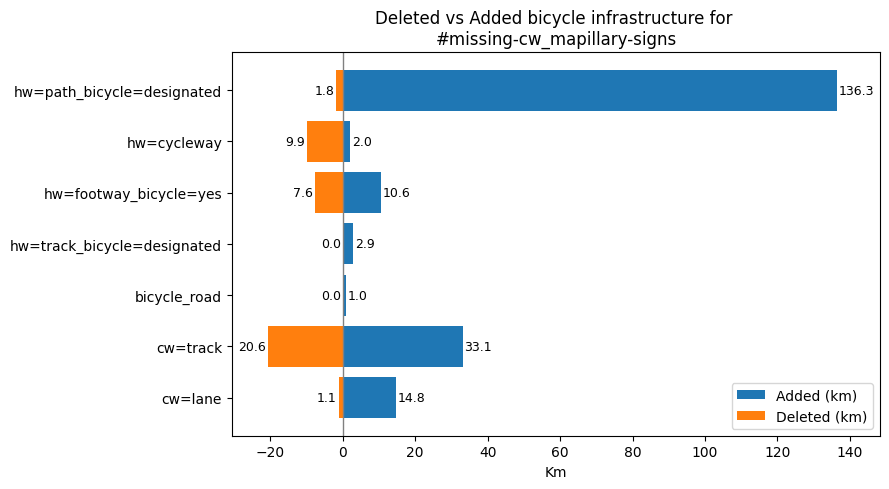

In [24]:
plt.figure(figsize=(9,5))

# reversed order
y = range(len(df))
added = df["km_added"][::-1]
deleted = df["km_deleted"][::-1]
cats = df["category"][::-1]

plt.barh(y, added, label="Added (km)")
plt.barh(y, -deleted, label="Deleted (km)")
plt.yticks(y, cats)

plt.xlabel("Km")
plt.title("Deleted vs Added bicycle infrastructure for \n#missing-cw_mapillary-signs")
plt.axvline(0, linewidth=1, color='gray')

# annotate values
for i, (a, d) in enumerate(zip(added, deleted)):
    plt.text(a + 0.5, i, f"{a:.1f}", va='center', ha='left', fontsize=9)
    plt.text(-d - 0.5, i, f"{d:.1f}", va='center', ha='right', fontsize=9)

# --- add padding around data range ---
min_val = deleted.max()
max_val = added.max()
plt.xlim(-min_val -10, max_val +12)  # 15% padding on both sides

plt.legend()
plt.tight_layout()
plt.show()


### Tag veränderungen

In [19]:
duckdb.sql("""
WITH base AS (
  SELECT
    usr.name AS mapper,
    tags,
    tags_before,
    length                               AS len_after_m,
    length - COALESCE(length_delta, 0)   AS len_before_m,
    COALESCE(length_delta, 0)            AS dlen_m
  FROM tmp3
  WHERE osm_type='way'
    AND tags['highway'] IS NOT NULL
    AND length IS NOT NULL
),
flag AS (
  SELECT
    mapper,
    len_after_m,
    len_before_m,
    dlen_m,
    (tags['traffic_sign']     IS NOT NULL) AS after_sign,
    (tags_before['traffic_sign'] IS NOT NULL) AS before_sign
  FROM base
),
agg AS (
  SELECT
    mapper,
    -- added: neu hinzugekommen oder verlängert
    SUM(CASE WHEN after_sign AND NOT before_sign THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN after_sign AND before_sign THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_m,
    -- deleted: entfernt oder verkürzt
    SUM(CASE WHEN before_sign AND NOT after_sign THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN before_sign AND after_sign THEN -LEAST(dlen_m,0) ELSE 0 END) AS del_m
  FROM flag
  GROUP BY mapper
)
SELECT
  mapper,
  ROUND(add_m/1000.0, 2) AS km_added,
  ROUND(del_m/1000.0, 2) AS km_deleted
FROM agg
ORDER BY km_added DESC;
""")


┌────────────────┬──────────┬────────────┐
│     mapper     │ km_added │ km_deleted │
│    varchar     │  double  │   double   │
├────────────────┼──────────┼────────────┤
│ bicyclett      │    157.0 │       6.56 │
│ mcliquid       │     3.08 │        0.0 │
│ KoiAndBlueBird │     0.69 │        0.0 │
│ chwiggy        │     0.29 │        0.0 │
│ Christopher    │     0.16 │        0.0 │
│ mfdz           │     0.14 │        0.0 │
│ tordans        │     0.07 │        0.0 │
│ Geofreund1     │     0.07 │        0.0 │
│ MrMoehritz     │     0.04 │        0.0 │
│ ofr1tz         │      0.0 │        0.0 │
│ fx99           │      0.0 │        0.0 │
│ CaptainCarte   │      0.0 │        0.0 │
├────────────────┴──────────┴────────────┤
│ 12 rows                      3 columns │
└────────────────────────────────────────┘

In [21]:
duckdb.sql("""
WITH base AS (
  SELECT
    tags, tags_before,
    length                               AS len_after_m,
    length - COALESCE(length_delta, 0)   AS len_before_m,
    COALESCE(length_delta, 0)            AS dlen_m
  FROM tmp3
  WHERE osm_type='way'
    AND tags['highway'] IS NOT NULL
    AND length IS NOT NULL
),
flags AS (
  SELECT
    len_after_m, len_before_m, dlen_m,

    -- AFTER: Key existiert?
    (tags['traffic_sign'] IS NOT NULL) AS a_traffic_sign,
    (tags['surface']      IS NOT NULL) AS a_surface,
    (tags['segregated']   IS NOT NULL) AS a_segregated,
    (tags['bicycle']      IS NOT NULL) AS a_bicycle,
    (tags['oneway']       IS NOT NULL) AS a_oneway,

    -- BEFORE: Key existierte?
    (tags_before['traffic_sign'] IS NOT NULL) AS b_traffic_sign,
    (tags_before['surface']      IS NOT NULL) AS b_surface,
    (tags_before['segregated']   IS NOT NULL) AS b_segregated,
    (tags_before['bicycle']      IS NOT NULL) AS b_bicycle,
    (tags_before['oneway']       IS NOT NULL) AS b_oneway
  FROM base
),
agg AS (
  SELECT
    -- traffic_sign
    SUM(CASE WHEN a_traffic_sign AND NOT b_traffic_sign THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_traffic_sign AND     b_traffic_sign THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_traffic_sign,
    SUM(CASE WHEN b_traffic_sign AND NOT a_traffic_sign THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_traffic_sign AND     a_traffic_sign THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_traffic_sign,

    -- surface
    SUM(CASE WHEN a_surface AND NOT b_surface THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_surface AND     b_surface THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_surface,
    SUM(CASE WHEN b_surface AND NOT a_surface THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_surface AND     a_surface THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_surface,

    -- segregated
    SUM(CASE WHEN a_segregated AND NOT b_segregated THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_segregated AND     b_segregated THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_segregated,
    SUM(CASE WHEN b_segregated AND NOT a_segregated THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_segregated AND     a_segregated THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_segregated,

    -- bicycle
    SUM(CASE WHEN a_bicycle AND NOT b_bicycle THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_bicycle AND     b_bicycle THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_bicycle,
    SUM(CASE WHEN b_bicycle AND NOT a_bicycle THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_bicycle AND     a_bicycle THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_bicycle,

    -- oneway
    SUM(CASE WHEN a_oneway AND NOT b_oneway THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_oneway AND     b_oneway THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_oneway,
    SUM(CASE WHEN b_oneway AND NOT a_oneway THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_oneway AND     a_oneway THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_oneway
  FROM flags
)
SELECT 'traffic_sign' AS tag, ROUND(add_traffic_sign/1000.0,1) AS km_added, ROUND(del_traffic_sign/1000.0,1) AS km_deleted FROM agg
UNION ALL
SELECT 'surface',      ROUND(add_surface/1000.0,1),      ROUND(del_surface/1000.0,1)      FROM agg
UNION ALL
SELECT 'segregated',   ROUND(add_segregated/1000.0,1),   ROUND(del_segregated/1000.0,1)   FROM agg
UNION ALL
SELECT 'bicycle',      ROUND(add_bicycle/1000.0,1),      ROUND(del_bicycle/1000.0,1)      FROM agg
UNION ALL
SELECT 'oneway',       ROUND(add_oneway/1000.0,1),       ROUND(del_oneway/1000.0,1)       FROM agg
ORDER BY tag;
""")

┌──────────────┬──────────┬────────────┐
│     tag      │ km_added │ km_deleted │
│   varchar    │  double  │   double   │
├──────────────┼──────────┼────────────┤
│ bicycle      │    112.7 │       10.5 │
│ oneway       │    108.7 │        7.7 │
│ segregated   │    121.0 │        8.9 │
│ surface      │     33.4 │       14.1 │
│ traffic_sign │    161.5 │        6.6 │
└──────────────┴──────────┴────────────┘

In [60]:
deleted.max()

np.float64(20.6)

In [12]:
duckdb.sql("""
SELECT MAX(valid_from) AS max_valid_from
FROM read_parquet(
  ['/home/simon/ohsome-planet/out-berlin_cs/contributions/history/*-*-history-contribs.parquet',
   '/home/simon/ohsome-planet/out-berlin_cs/contributions/latest/*-*-latest-contribs.parquet'],
  union_by_name = true
);
""").show()

┌──────────────────────────┐
│      max_valid_from      │
│ timestamp with time zone │
├──────────────────────────┤
│ 2025-10-06 01:57:52+02   │
└──────────────────────────┘



In [20]:
import duckdb
duckdb.sql("""
DESCRIBE SELECT * 
FROM read_parquet('/home/simon/ohsome-planet/out-berlin_cs/contributions/history/way-*-history-contribs.parquet')
""").df()


,column_name,column_type,null,key,default,extra
0,status,VARCHAR,YES,None,None,None
1,valid_from,TIMESTAMP WITH TIME ZONE,YES,None,None,None
2,valid_to,TIMESTAMP WITH TIME ZONE,YES,None,None,None
3,osm_type,VARCHAR,YES,None,None,None
4,osm_id,BIGINT,YES,None,None,None
5,osm_version,INTEGER,YES,None,None,None
6,osm_minor_version,INTEGER,YES,None,None,None
7,osm_edits,INTEGER,YES,None,None,None
8,osm_last_edit,TIMESTAMP WITH TIME ZONE,YES,None,None,None
9,user,"STRUCT(id INTEGER, ""name"" VARCHAR)",YES,None,None,None
